In [624]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

%matplotlib inline
np.random.seed(123)

In [625]:
#Data split 
# Download training data from open datasets.

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

batch_size = 64
sete_set = [x for x, y in training_data if y == 7]
test_sete_set = [x for x, y in test_data if y == 7]

# print(len(sete_set))
# print(len(test_sete_set))
#test_sete_set = np.array(test_sete_set).astype(np.float32)
#sete_set = np.array(sete_set).astype(np.float32)

test_sete_dataloader = DataLoader(test_sete_set, batch_size=batch_size)
sete_dataloader = DataLoader(sete_set, batch_size=batch_size)

a = next(iter(sete_dataloader))
print(torch.min(a[0, :]))
print(torch.max(a[0, :]))

print(len(sete_dataloader.dataset))

tensor(0.)
tensor(1.)
6265


In [626]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 10)
        )

        self.decoder = nn.Sequential(
            nn.Linear(10, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )


    def forward(self, x):
        flat_x = self.flatten(x)
        latente = self.encoder(flat_x)
        pred = self.decoder(latente)

        return pred
    
        #self.lay = 6
        #self.decoder.apply(self._init_enc_weights)
        #self.encoder.apply(self._init_dec_weights)
     
        # print(self.encoder)
        # print(self.decoder)    
        # print(self.encoder[0].weight.data[:2,:2])
        # print(self.decoder[6].weight.data[:2,:2].T)
        # print(self.encoder[2].weight.data[:2,:2])
        # print(self.decoder[4].weight.data[:2,:2].T)
        # print(self.encoder[4].weight.data[:2,:2])
        # print(self.decoder[2].weight.data[:2,:2].T)
        # print(self.encoder[6].weight.data[:2,:2])
        # print(self.decoder[0].weight.data[:2,:2].T)


    # def _init_enc_weights(self, module):

    #     if isinstance(module, nn.Linear):
    #         module.weight.data = nn.init.xavier_uniform_(module.weight.data)

    #         if module.bias is not None:
    #             module.bias.data.zero_()

            #print(module.weight.data[:2, :2])


    # def _init_dec_weights(self, module):

    #     if isinstance(module, nn.Linear):
    #         #print(module)
    #         module.weight.data = self.decoder[self.lay].weight.T
            
    #         if module.bias is not None:
    #             module.bias.data.zero_()

    #         # print(module.weight.data.shape)
    #         # print(module.weight.data[:2, :2].T)
    #         self.lay -= 2


In [627]:
class CNNAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), #16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # 64, 1, 1
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        reconst = self.decoder(encoded)

        return reconst

In [628]:
loss = nn.MSELoss()

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu" 
print(f"using {device} device")
 
model_7 = AutoEncoder().to(device=device)
CNN_model_7 = CNNAutoEncoder().to(device=device)
learning_rate = 1e-3
cnn_optm = torch.optim.Adam(CNN_model_7.parameters(), lr=learning_rate)
optm = torch.optim.Adam(model_7.parameters(), lr=learning_rate)

using mps device


In [629]:
def train(data, model, loss_fn, opt, cnn=False):

    #pega data
    for X in tqdm(data):
        X = X.to(device=device)
        pred = model(X)
        if not cnn: X = torch.reshape(X, (X.shape[0], 28*28))
        loss = loss_fn(pred, X)
        
        opt.zero_grad()
        loss.backward()
        opt.step()


def test(data, model, loss_fn, cnn=False):

    num_batches = len(data)
    loss = 0
    model.eval()

    with torch.no_grad():
        for X in data:
            X = X.to(device=device)
            if not cnn: X = torch.reshape(X, (X.shape[0], 28*28))
            pred = model(X)
            loss += loss_fn(pred, X).item()
        
        loss /= num_batches

    print(f"Loss: {loss:.5f}")


In [630]:
epochs = 15

for i in range(epochs):
    train(sete_dataloader, model_7, loss, opt=optm)
    test(test_sete_dataloader, model_7, loss)
    

100%|██████████| 98/98 [00:01<00:00, 89.06it/s]


Loss: 0.04629


100%|██████████| 98/98 [00:00<00:00, 98.94it/s] 


Loss: 0.03963


100%|██████████| 98/98 [00:00<00:00, 107.17it/s]


Loss: 0.02876


100%|██████████| 98/98 [00:00<00:00, 110.50it/s]


Loss: 0.02619


100%|██████████| 98/98 [00:00<00:00, 109.28it/s]


Loss: 0.02481


100%|██████████| 98/98 [00:00<00:00, 109.55it/s]


Loss: 0.02192


100%|██████████| 98/98 [00:00<00:00, 110.52it/s]


Loss: 0.02090


100%|██████████| 98/98 [00:00<00:00, 108.56it/s]


Loss: 0.01940


100%|██████████| 98/98 [00:00<00:00, 105.07it/s]


Loss: 0.01801


100%|██████████| 98/98 [00:00<00:00, 107.72it/s]


Loss: 0.01738


100%|██████████| 98/98 [00:00<00:00, 108.73it/s]


Loss: 0.01698


100%|██████████| 98/98 [00:00<00:00, 110.36it/s]


Loss: 0.01666


100%|██████████| 98/98 [00:00<00:00, 109.12it/s]


Loss: 0.01639


100%|██████████| 98/98 [00:01<00:00, 97.02it/s] 


Loss: 0.01606


100%|██████████| 98/98 [00:00<00:00, 98.58it/s] 

Loss: 0.01568


In [631]:
epochs = 15
outputs = []
for i in range(epochs):
    train(sete_dataloader, CNN_model_7, loss, opt=cnn_optm, cnn=True)
    test(test_sete_dataloader, CNN_model_7, loss, cnn=True)

100%|██████████| 98/98 [00:02<00:00, 43.56it/s]


Loss: 0.04786


100%|██████████| 98/98 [00:00<00:00, 120.96it/s]


Loss: 0.04625


100%|██████████| 98/98 [00:00<00:00, 125.96it/s]


Loss: 0.03115


100%|██████████| 98/98 [00:00<00:00, 126.77it/s]


Loss: 0.01777


100%|██████████| 98/98 [00:00<00:00, 126.82it/s]


Loss: 0.01256


100%|██████████| 98/98 [00:00<00:00, 125.61it/s]


Loss: 0.01001


100%|██████████| 98/98 [00:00<00:00, 114.49it/s]


Loss: 0.00870


100%|██████████| 98/98 [00:00<00:00, 124.78it/s]


Loss: 0.00763


100%|██████████| 98/98 [00:00<00:00, 124.71it/s]


Loss: 0.00681


100%|██████████| 98/98 [00:00<00:00, 124.66it/s]


Loss: 0.00618


100%|██████████| 98/98 [00:00<00:00, 123.86it/s]


Loss: 0.00567


100%|██████████| 98/98 [00:00<00:00, 125.41it/s]


Loss: 0.00525


100%|██████████| 98/98 [00:00<00:00, 124.64it/s]


Loss: 0.00493


100%|██████████| 98/98 [00:00<00:00, 120.25it/s]


Loss: 0.00467


100%|██████████| 98/98 [00:00<00:00, 125.75it/s]


Loss: 0.00446


In [632]:
def plot_img(x):
    try:
        x = x.cpu().detach().numpy().reshape(28,28)
    except AttributeError:
        x = x.reshape(-1, 28)

    #plt.plot([:28], [:28])
    plt.imshow(x, cmap='gray')
    plt.show()
    #plt.savefig(f'{i}.png')
    plt.close()

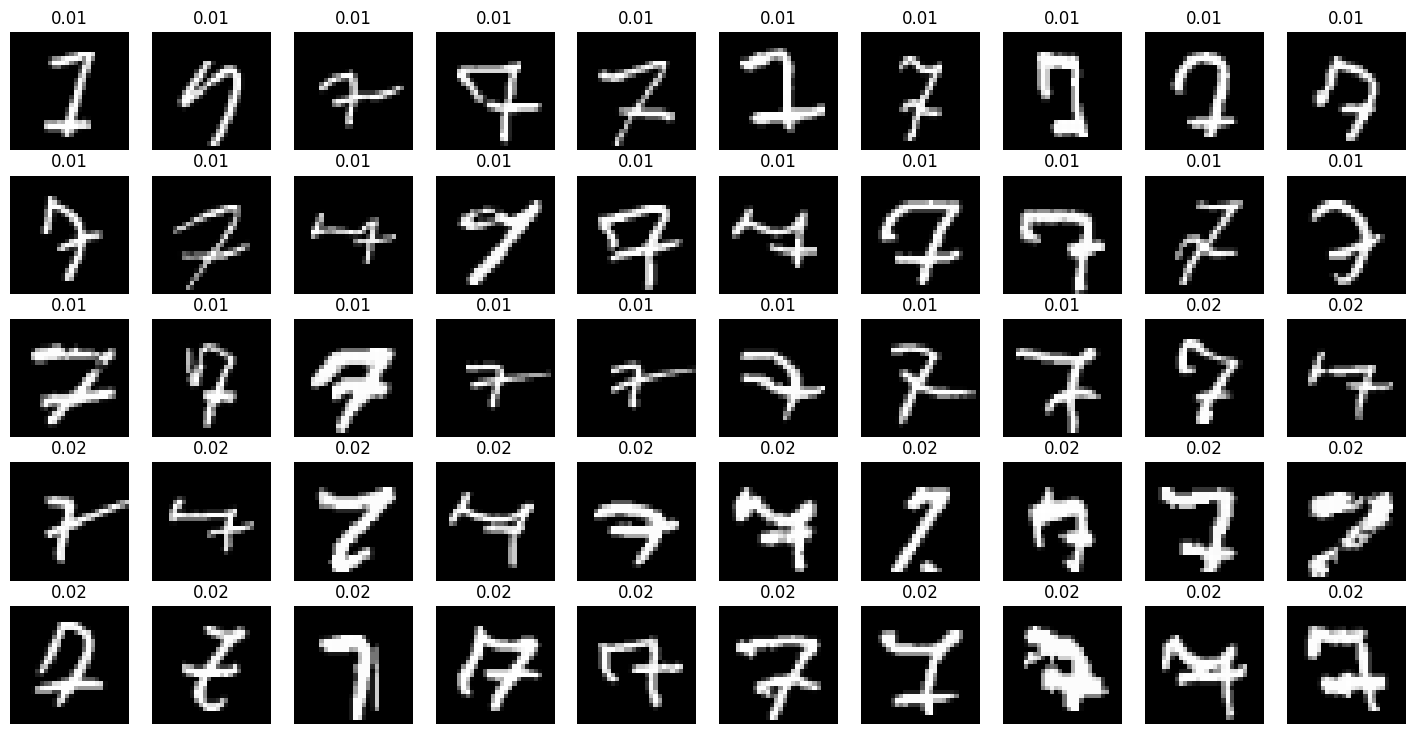

In [635]:
num_max_errors = 50
errors = []
max_error = 0
pred_max_err = []
X_max_err = []


for j, X in enumerate(sete_dataloader):
    X = X.to(device)
    mean = 0
    pred = CNN_model_7(X)
    #X = torch.reshape(X, (X.shape[0], 28*28))

    for i in range(pred.shape[0]):
        l = loss(pred[i, :], X[i, :]).item()
        errors.append(l)
        
        if l > max_error:
            max_error = l
            pred_max_err = pred[i, :]
            X_max_err = X[i, :]


rrors = np.array(errors)
sort_err = np.argsort(errors)

max_loss = sort_err[-50:]
fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(18,9))
for i, ax in enumerate(axes.flatten()):
    idx = max_loss[i]
    ax.set_title(f"{rrors[idx]:.2f}")
    ax.imshow(sete_set[idx].reshape(-1, 28), cmap="gray")
    ax.axis("off")

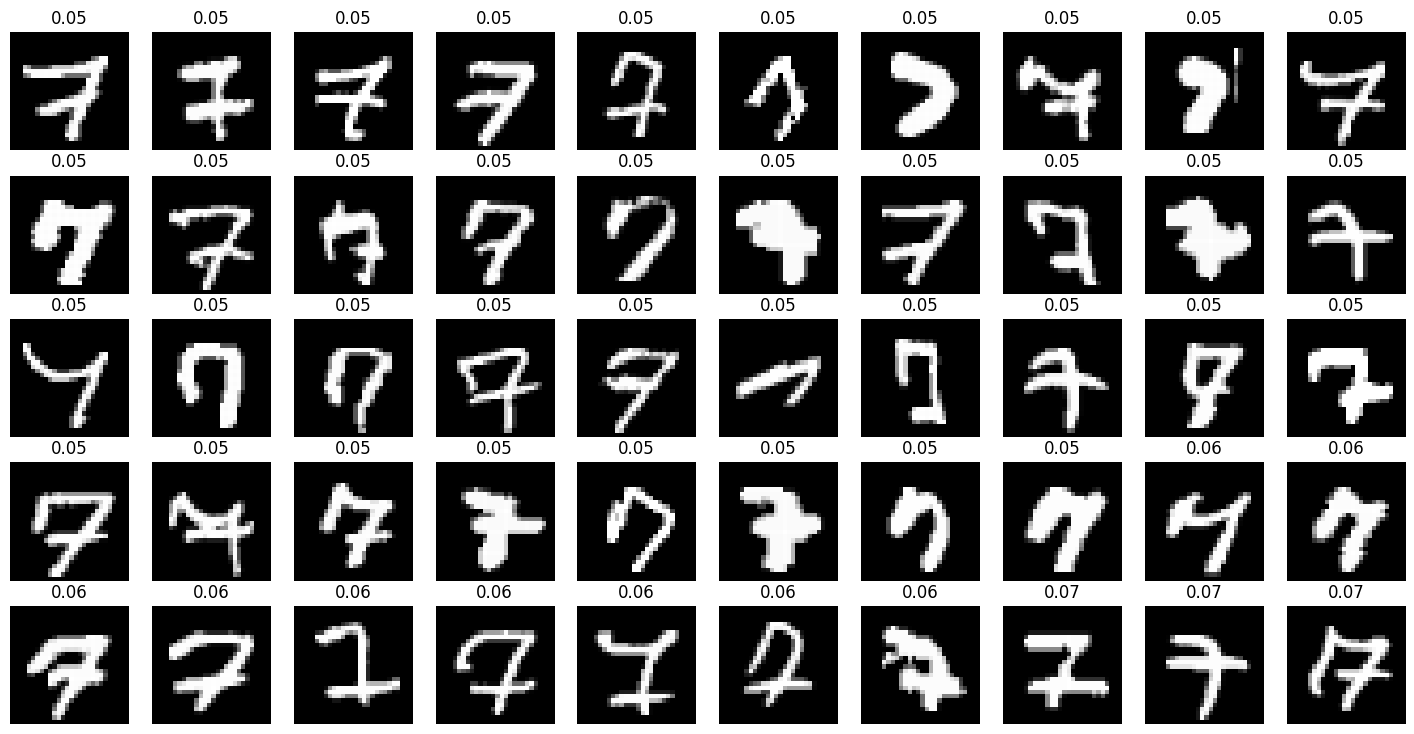

In [636]:
num_max_errors = 50
errors = []
max_error = 0
pred_max_err = []
X_max_err = []


for j, X in enumerate(sete_dataloader):
    X = X.to(device)
    mean = 0
    pred = model_7(X)
    X = torch.reshape(X, (X.shape[0], 28*28))

    for i in range(pred.shape[0]):
        l = loss(pred[i, :], X[i, :]).item()
        errors.append(l)
        
        if l > max_error:
            max_error = l
            pred_max_err = pred[i, :]
            X_max_err = X[i, :]


rrors = np.array(errors)
sort_err = np.argsort(errors)

max_loss = sort_err[-50:]
fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(18,9))
for i, ax in enumerate(axes.flatten()):
    idx = max_loss[i]
    ax.set_title(f"{rrors[idx]:.2f}")
    ax.imshow(sete_set[idx].reshape(-1, 28), cmap="gray")
    ax.axis("off")

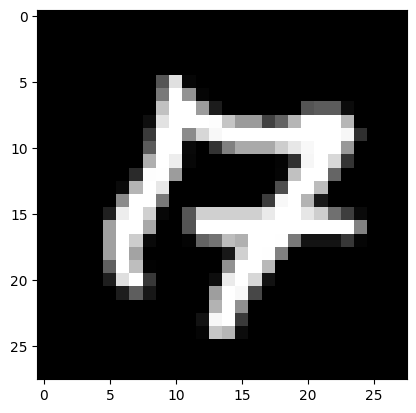

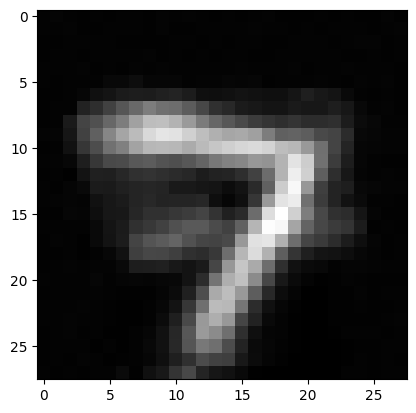

In [637]:
rrors[max_loss[-1]]
plot_img(sete_set[max_loss[-1]])
plot_img(pred_max_err)

In [ ]:
print(model_7.encoder[6].weight)
print(model_7.decoder[0].weight.T)
print(f"GRAD enc: {model_7.encoder[6].weight.grad}")
#print(f"GRAD enc 2: {model_7.encoder[2].weight.grad}")
print(f"GRAD dec: {model_7.decoder[0].weight.grad.T}")

print(model_7.encoder[6].weight.shape)
print(model_7.decoder[0].weight.T.shape)

Parameter containing:
tensor([[-9.7652e-02,  8.5723e-02,  1.1302e-01,  6.6762e-02,  1.0561e-01,
         -4.7256e-02,  6.8632e-02,  7.4484e-02, -8.7838e-02, -1.8515e-02,
         -7.4615e-02,  4.9231e-02, -3.6367e-03, -1.1560e-01,  3.0645e-03,
         -8.0008e-02,  1.7046e-01, -3.6167e-02,  2.5975e-02,  1.7718e-02,
         -1.2638e-01, -5.4732e-02,  1.2102e-03, -1.0730e-01,  1.4195e-01,
          1.1776e-01, -1.1388e-01,  1.2779e-01, -1.2239e-01, -1.2197e-01,
          8.7868e-02, -8.6333e-02, -1.0732e-01, -5.3030e-02, -5.0146e-02,
          1.1926e-01, -1.0699e-01,  1.5213e-01, -1.5647e-02,  8.6523e-02,
         -6.4084e-02, -6.4104e-02,  1.1752e-01, -2.0226e-02,  8.9086e-02,
         -1.5637e-01, -4.9401e-02,  2.4196e-02,  1.1436e-01, -5.4460e-02,
         -7.6561e-02,  1.7115e-02,  5.1026e-03,  1.6435e-02, -2.8568e-02,
          3.2646e-02,  3.9200e-02, -5.2670e-04,  1.7062e-02, -7.9570e-02,
          4.1922e-02, -6.7473e-02,  1.0274e-01, -1.3200e-02],
        [-7.0897e-02, -5.788